# drosophila_simulation_varying_shear_modulus

> copy of notebook `04_drosophila_simulation`, measure tissue extension with varying shear moduli

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Might be better to make this more gradual. 

### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
importlib.reload(msh)
importlib.reload(tns)
importlib.reload(dln)
importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
## create and plot the initial condition
## create and plot the initial condition

mesh_initial, property_dict = drs.create_rect_initial(20, 24, noise=0.1, initial_strain=0.1,
                                                      orientation='orthogonal', isogonal=0,
                                                      boundaries=['top', 'bottom',], #'left', 'right'
                                                      w_passive=5.5, w_passive_lr=0, random_seed=3)

In [ ]:
# 5.5 vs 4.5 passive

In [ ]:
# set colors for edges and cells
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5

cell_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.vertices.keys()
                      if not key in property_dict['passive_cells']}

(-8.5, 8.5, -11.5, 11.5)

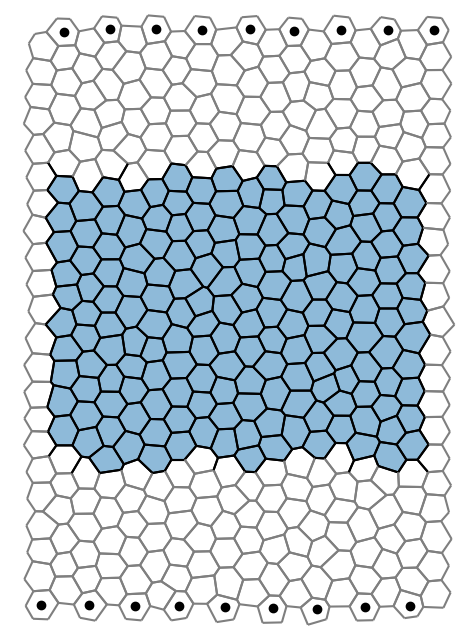

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    #plt.hlines((bdry_y-.25, -bdry_y+.25), (-9, -9), (9, 9), color="k")
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

plt.axis("off")

## set simulation parameters

In [ ]:
# might need much larger k for passive

In [ ]:
## feedback parameters

m = 4
k = .5  # . 5
k_cutoff = .1 # regularization term
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .15, "m": 1} # lower k here makes the passive region less lattice-like
    # might add an extra case for the edges in slip-wall boundary cells
    return {"k": k, "m": m, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .005 # time step
n_steps = 100
forbid_reflip = 20
minimal_l = .05 # .075 inimal edge length, lower edge lengths trigger T1

tri_mod_area = .02 # .01 triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 100000)  #1e-4
mod_bulk = 1
mod_shear = 0.5 #.25 # .5

angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = (1e-3, 1e-4)  # interesting. going below 1e-3 leads the optimizer to fail, typically.

A0 = jnp.sqrt(3)/2
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area, "P0": P0, "mod_perimeter": mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 0

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if (v._vid in property_dict['passive_cells'])  and (not v.is_bdry()):
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0
    #delta = v.rest_shape-v.get_vrtx_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

Few if any recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = True
save_dir = f"runs/extension_elasticity_control_copy1"
try:
    os.mkdir(save_dir)
except FileExistsError:
    print('Warning: directory exists')
drs.save_self(save_dir, fname='04b_drosophila_simulation_varying_shear_modulus.ipynb')

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(len(meshes)-1, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    if flipped and not failed_flip:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])


  0%|          | 0/100 [00:00<?, ?it/s]

tpt 3: flip [2442]
tpt 9: flip [1585, 985, 1323]
tpt 11: flip [1702, 2124]
tpt 13: flip [916, 2101]
tpt 15: flip [1596]
tpt 16: flip [2181, 819]
tpt 17: flip [940]
tpt 19: flip [889, 1126]
tpt 20: flip [988, 1119]
tpt 21: flip [1330, 828]
tpt 22: flip [691]
tpt 23: flip [346, 2137, 594]
tpt 24: flip [910, 837, 954, 1971, 2208]
tpt 25: flip [352, 960, 1720]
tpt 26: flip [1614, 882, 400, 154]
tpt 27: flip [886]
tpt 28: flip [361, 19, 918]
tpt 29: flip [433, 2121, 304, 1290]
tpt 30: flip [2553]
tpt 31: flip [427, 459, 2166, 2107]
tpt 32: flip [333, 939, 1692]
tpt 33: flip [2160, 1098, 2068]
tpt 34: flip [916, 903, 897]
tpt 35: flip [313, 1383]
tpt 36: flip [1587, 1113]
tpt 37: flip [1704, 331, 387, 1569]
tpt 38: flip [936, 2157, 1089, 972, 1311, 1686]
tpt 39: flip [1591, 2421, 457, 429, 1284, 2215, 1375, 69]
tpt 40: flip [84, 541, 2460]
tpt 41: flip [1815]
tpt 42: flip [828, 2437, 1182, 574, 1744]
tpt 43: flip [2097, 1030]
tpt 44: flip [12, 2137, 1053, 616]
tpt 45: flip [66, 1863, 526]
tp

In [ ]:
last_flipped_edges.append([])

with open(save_dir+'/last_flipped_edges.pickle', 'wb') as handle:
    pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
meshes[-1].is_consistent()

### Loading a saved simulation

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

save_dir = "plots/for_figure_v3/trajectories_large"
meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh', load_attribs=False) 
          for i in tqdm(range(0, 240, 1))]

  0%|          | 0/240 [00:00<?, ?it/s]

### Slider plots

In [ ]:
mod_shear

0.01

<IPython.core.display.Javascript object>


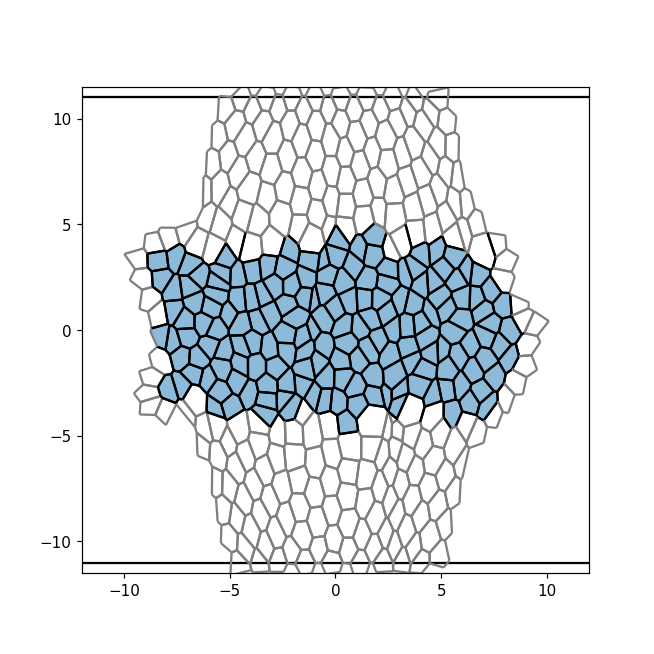

interactive(children=(IntSlider(value=50, description='i'), FloatSlider(value=12.0, description='xlim', max=16…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
    
# fix the arguments which you do not need to tune with widgets.fixed

widgets.interact(drs.plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(bdry_y),
                 edge_colors=widgets.fixed(edge_colors), cell_colors=widgets.fixed(cell_colors_active),
                 mesh_series=widgets.fixed(meshes),
                 flipped_series=widgets.fixed(None),
                 #flipped_series=widgets.fixed(last_flipped_edges)
                );


In [ ]:
%matplotlib inline

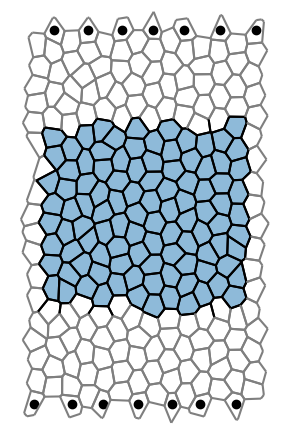

In [ ]:
fig = plt.figure(figsize=(3,6))

t = 5

meshes[t].cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*meshes[t].vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
plt.tight_layout()

plt.savefig("plots/for_figure_v3/no_shear_initial.pdf")

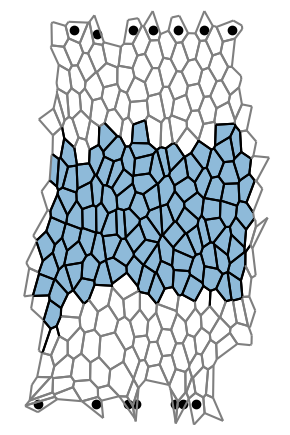

In [ ]:
fig = plt.figure(figsize=(3,6))

t = 105

meshes[t].cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*meshes[t].vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
plt.tight_layout()

plt.savefig("plots/for_figure_v3/no_shear_final.pdf")

## Measure extension

In [ ]:
%matplotlib inline

In [ ]:
# load all the relevant meshes

moduli = [0, 0.0625, 0.125, 0.25, 0.5, 1]
meshes_dict = {}
for m in moduli:
    save_dir = f"plots/SI figs and movies/shear_modulus_{m}"
    meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh', load_attribs=False) 
              for i in tqdm(range(0, 150, 1))]
    meshes_dict[m] = meshes


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# overlay initial and final positions of active cell vertices

centroids_dict = {}
for key, val in meshes_dict.items():
    centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                           if key not in property_dict["passive_cells"] and not v.is_bdry()]
                           for mesh in val[1:]])
    centroids_dict[key] = centroids

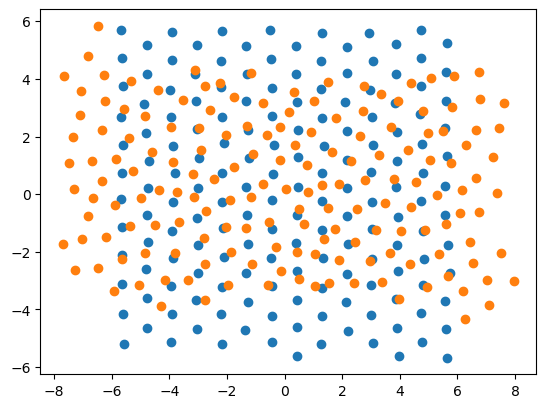

In [ ]:
plt.scatter(*centroids_dict[1][1].T)
plt.scatter(*centroids_dict[1][-1].T)

plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
sigma = 2


delta_dict = {}
delta_dict_no_log = {}

for key, val in centroids_dict.items():
    delta = np.quantile(val, axis=1, q=.9)-np.quantile(val, axis=1, q=.1,)
    delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
    delta_smooth /= delta_smooth[0]
    delta_dict_no_log[key] = delta_smooth
    delta_log = np.log(delta_smooth)
    delta_dict[key] = delta_log

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

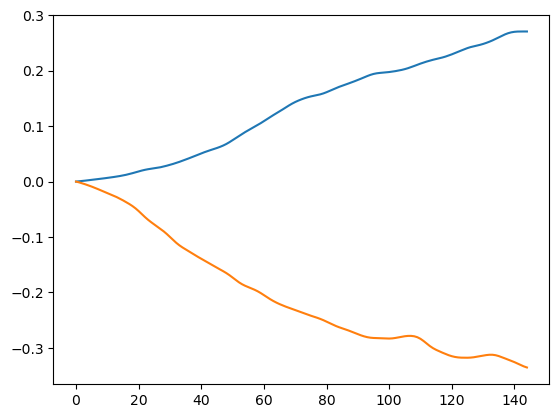

In [ ]:
plt.plot(delta_dict[1])

In [ ]:
import numpy as np

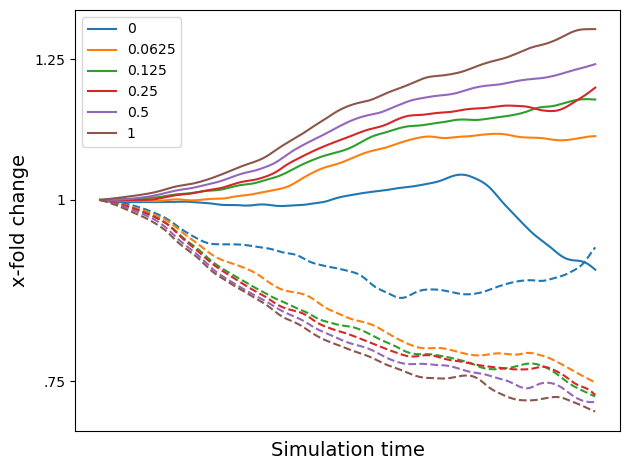

In [ ]:
time = np.arange(delta_smooth.shape[0])


for key, val in delta_dict.items():
    plt.plot(time, val[:,0], label=f'{key}')
    c = plt.gca().lines[-1].get_color()
    plt.plot(time, val[:,1], color=c, ls="--")




plt.yticks([np.log(.75), 0, np.log(1.25)], [".75", 1, "1.25"]);
plt.xticks([])


plt.xlabel('Simulation time', fontsize=14)
plt.ylabel('x-fold change', fontsize=14)
plt.legend()

plt.tight_layout()

#plt.gca().twinx().plot((vals[:,1]**2-vals[:,0]**2) / (vals[:,1]**2+vals[:,0]**2), color="k")

plt.savefig("plots/SI figs and movies/extension_vs_time_multiple_shear_moduli.pdf")

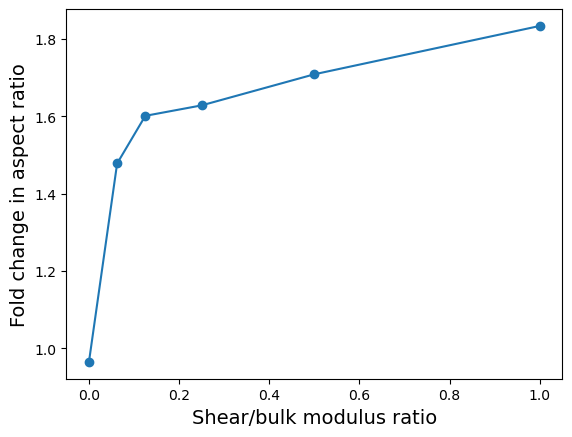

In [ ]:
aspect_ratio_change = np.array([[key, val[-1][0] / val[-1][1] ] for key, val in delta_dict_no_log.items()]).T

plt.plot(aspect_ratio_change[0], aspect_ratio_change[1], marker='o')

plt.xlabel("Shear/bulk modulus ratio", fontsize=14)
plt.ylabel("Fold change in aspect ratio", fontsize=14)

plt.savefig("plots/SI figs and movies/aspect_ratio_change_multiple_shear_moduli.pdf")

#plt.gca().set_xscale('log')

In [ ]:
aspect_ratio_change[0]

array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ])